# Fourth assignment: Network Robustness

In this assignment, we investigate the robustness of a network by simulating random failures and target attacks; we use different graphs: a random graph (with a connected regime), a scale-free graph (generated by the Barabasi-Albert model) and finally a real graph (Arxiv GR-QC).

Other than developing random failures, we focus also on target attacks in order to see which node removal strategy causes the most damage: we try to remove the node with the highest degree, closeness, betweenness, clustering coefficient, PageRank, and HITS score.

For each graph, we observe how these different failures affect the diameter, the average degree of the network and the size of the giant component (number of links).
We expect that the attack tolerance to random failures is much higher with respect to the target attacks: the fraction of nodes to remove in order to break the giant component is greater in the first case than in the second.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import multiprocessing

## 0. Failure utilities

In [80]:
def parallel_work(graph, idx, diam, deg, giant):
    diam[idx] = nx.diameter(graph)
    deg[idx] = np.mean(list(dict(graph.degree).values()))
    giant[idx] = graph.size()
    
def execute_failures_pool(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    
    i = 0
    diam_evol = multiprocessing.Manager().dict({i:nx.diameter(workingG)})
    deg_evol = multiprocessing.Manager().dict({i:np.mean(list(dict(workingG.degree).values()))})
    giant_evol = multiprocessing.Manager().dict({i:workingG.size()})
    
    pool = multiprocessing.Pool(processes=4)

    while len(workingG)>1:        
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)
        
        i+=1
        pool.apply_async(func=work, args=(workingG.copy(),i,diam_evol,deg_evol,giant_evol))
        
    pool.close()
    pool.join()
    
    diam_evol=list(map(lambda p:p[1], sorted(diam_evol.items(), key=lambda p:p[0])))
    deg_evol=list(map(lambda p:p[1], sorted(deg_evol.items(), key=lambda p:p[0])))
    giant_evol=list(map(lambda p:p[1], sorted(giant_evol.items(), key=lambda p:p[0])))
    
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}


def execute_failures_seq(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)

    diam_evol = [nx.diameter(workingG)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [workingG.size()]
    
    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)

        diam_evol.append(nx.diameter(workingG))
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        giant_evol.append(workingG.size())
    
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def plot_distribution(failDict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle("{} failures evolution".format(title))
 
    plt.subplot(121)
    plt.plot(failDict["Diameter evolution"], label="Diameter evolution")
    plt.plot(failDict["Average degree evolution"], label="Average degree evolution")
    plt.xlabel("#failures")
    plt.ylabel("value")
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(failDict["Giant component evolution"], label="Giant component evolution")
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    plt.legend()
    plt.grid()
    
def compare_attack(failDict, network):
    plt.figure(figsize=(15,8))
    plt.title("Evolution Comparison between different attack in a {} graph".format(network))
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    for attack, evolution in failDict.items():
        plt.plot(evolution, label=attack)
    plt.legend()
    plt.grid()
    
def compare_attack2(failDict, network):
    title = "Evolution Comparison between different attack in a {} graph".format(network)
    
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="#failures")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="GC size")
        )
    )
    
    data = []
    for attack, evolution in failDict.items():
        trace = go.Scatter(
            y=evolution,
            name=attack,
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

In [4]:
def random_ranking(graph):
    #return list(zip(np.random.permutation(graph.nodes()),range(1,graph.number_of_nodes()+1)))
    return np.random.choice(graph.nodes())

def metric_ranking(graph, metricFunction, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return max(metricDict.items(), key=lambda pair:pair[1])[0]

## 1. Erdős-Rényi random graph $[G_{np}]$
<h4>Connected regime $\left[p>\frac{\log{n}}{n}\right]$</h4>

In [5]:
n = 300
attackDict = {}

In [6]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=6.286666666666667


/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


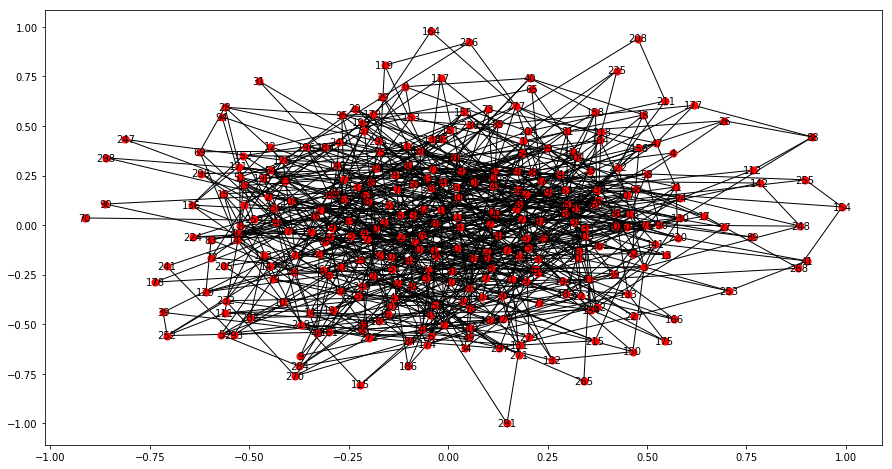

In [60]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [81]:
rand_failures = execute_failures_pool(G, random_ranking)

12.374341011047363


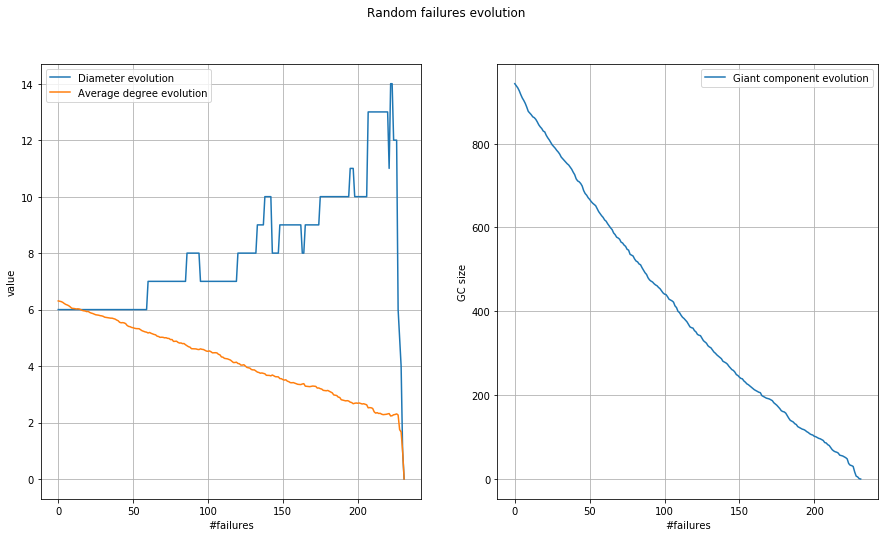

In [82]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

In [83]:
rand_failures = execute_failures_pool(G, random_ranking)

12.403864860534668


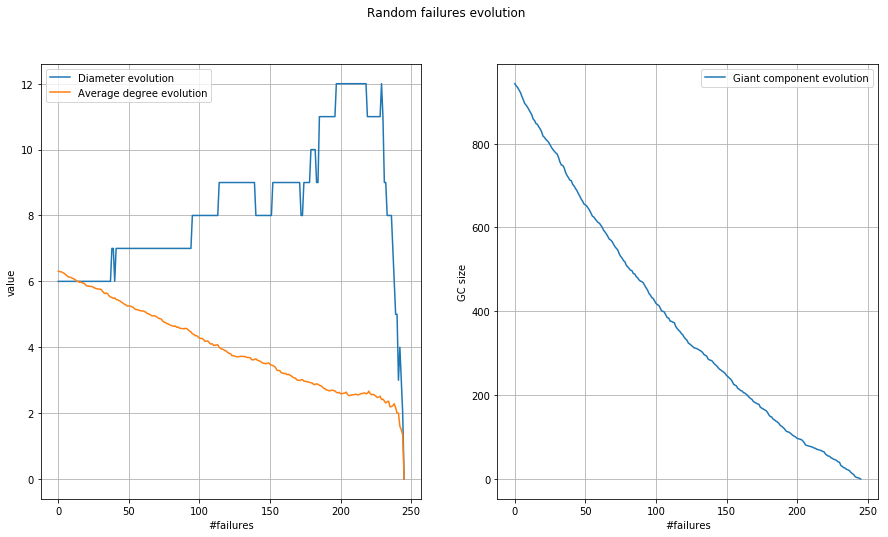

In [84]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

From the graph, we can observe that diameter increases, then decrease until it reaches a critical point in which collapse to zero (the giant component vanishes); it could be also observed that, when the giant component vanishes, the average degree become zero.
(In random failures comparing the total number of nodes with those eliminated, we could see that it requires the elimination of more than 70% of nodes in order to disrupt the giant component: in this case, the critical fraction of node is near 220 out of 300 total nodes).

### -- attacks over closeness

In [85]:
cls_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

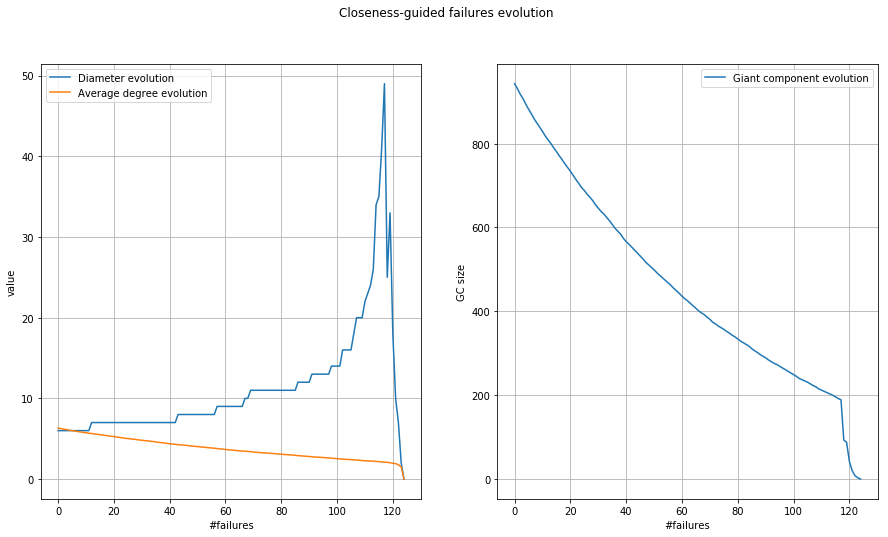

In [86]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [87]:
btw_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

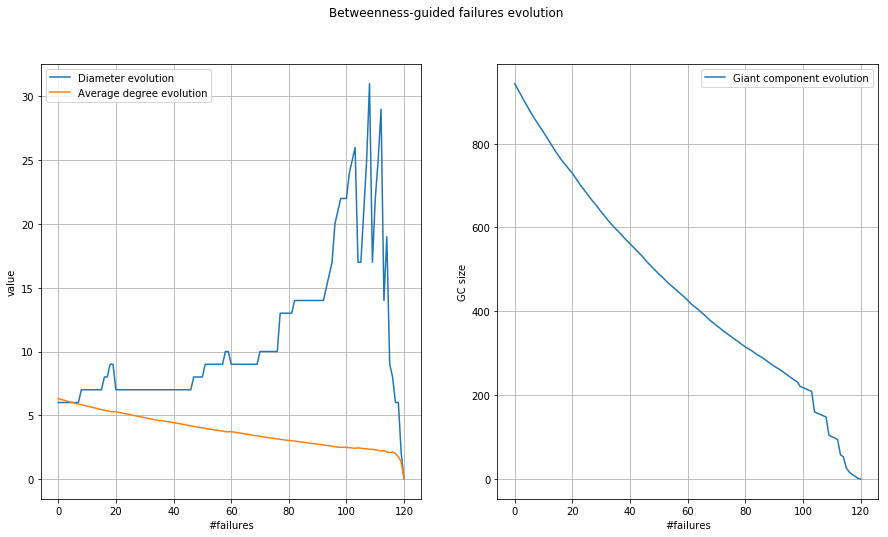

In [88]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over nodes degree

In [89]:
deg_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.degree})

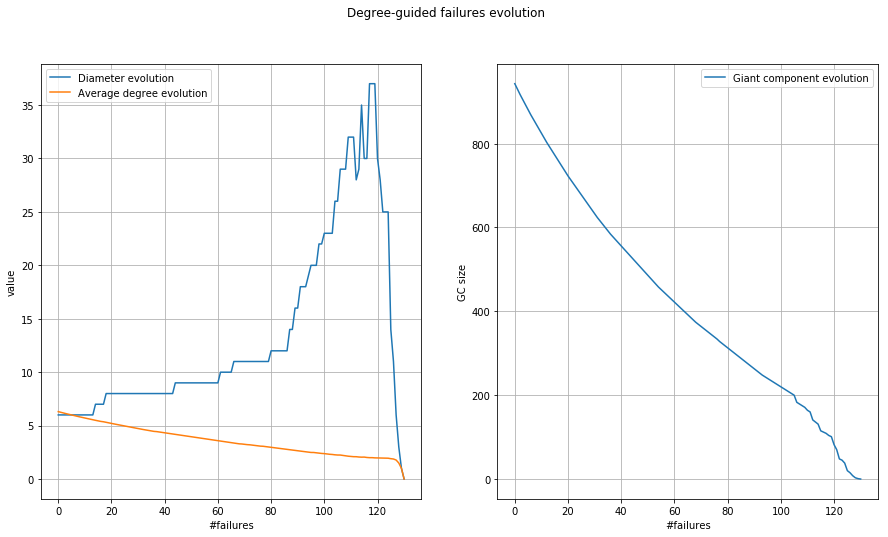

In [90]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over clustering coefficient

In [91]:
clt_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.clustering})

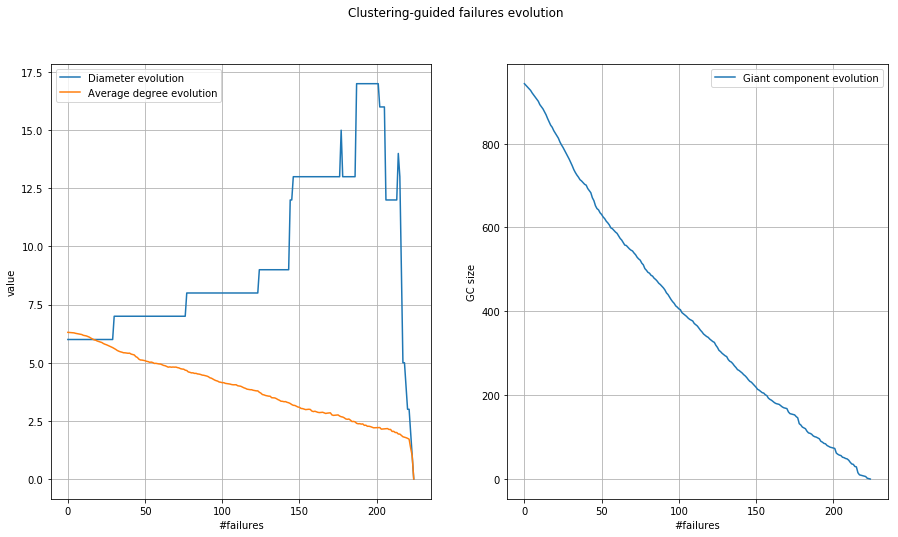

In [92]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [93]:
prk_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

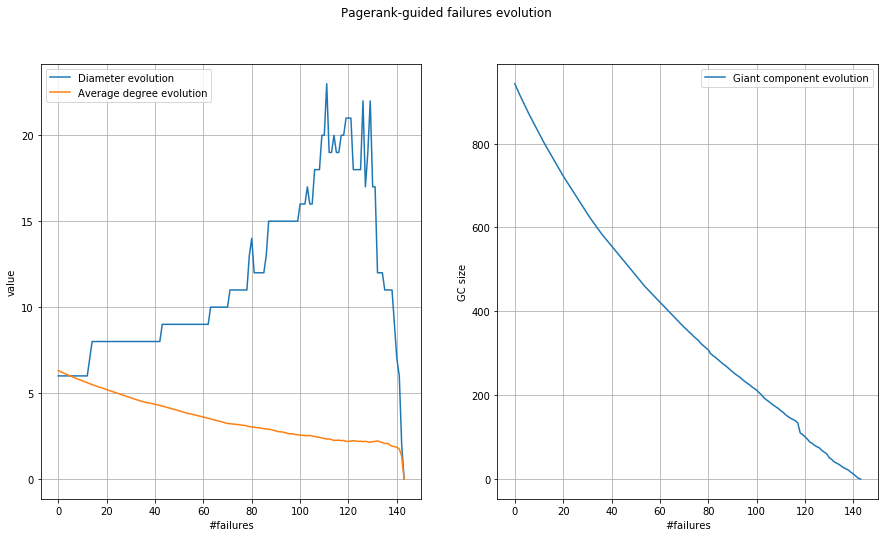

In [94]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [95]:
hit_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  hubs = dict(zip(G, map(float, h)))
/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/algorithms/link_analysis/hits_alg.py:208: ComplexWarning: Casting complex values to real discards the imaginary part
  authorities = dict(zip(G, map(float, a)))


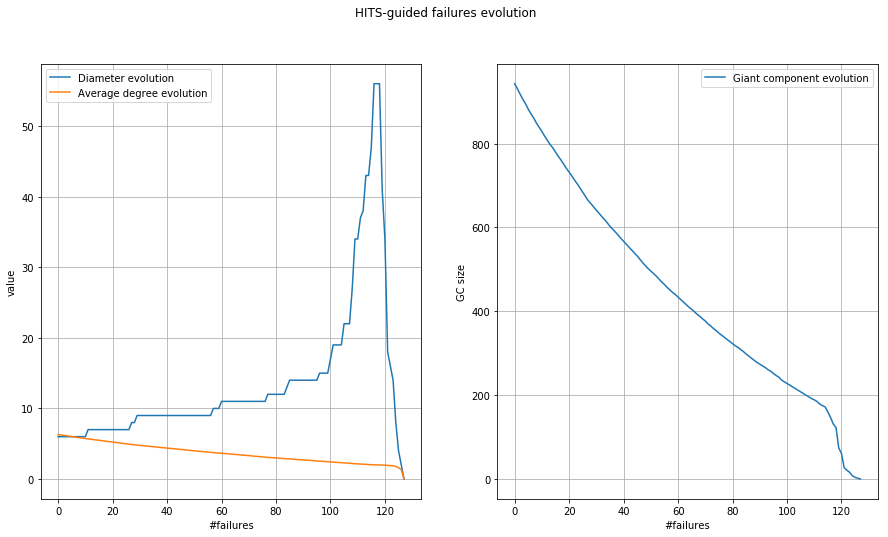

In [96]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

Observing plots from other kinds of attacks we should observe that the fraction required to “break” the giant component is less w.r.t the random failures.

The smallest fraction required in terms of the node is obtained deleting nodes with the highest betweenness, closeness and node degree (in this small test random graph most likely they end up being eventually the same nodes).

### -- attack comparison

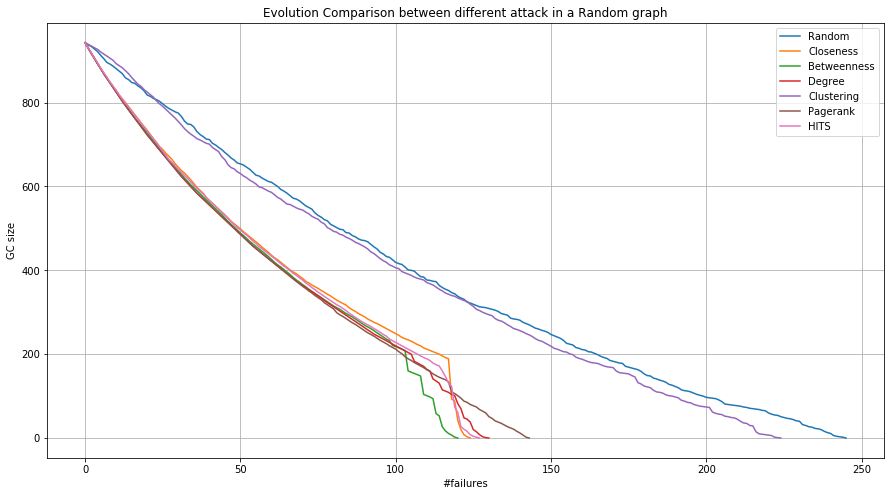

In [97]:
compare_attack(attackDict, "Random")

From this comparison plot, we could confirm what we have already stated: random failures require more node to delete in order to make the giant component vanishes; the worst target attack is that based on PageRank, this is probably due to the random network structure, which has very few hubs.

Again, the best target attack is which that delete nodes based on the betweenness.

## 2. Power law network

In [98]:
n = 300
attackDict = {}

In [99]:
G = nx.barabasi_albert_graph(n,2)
pos = nx.spring_layout(G)
print("<k>={}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

<k>=3.973333333333333


/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


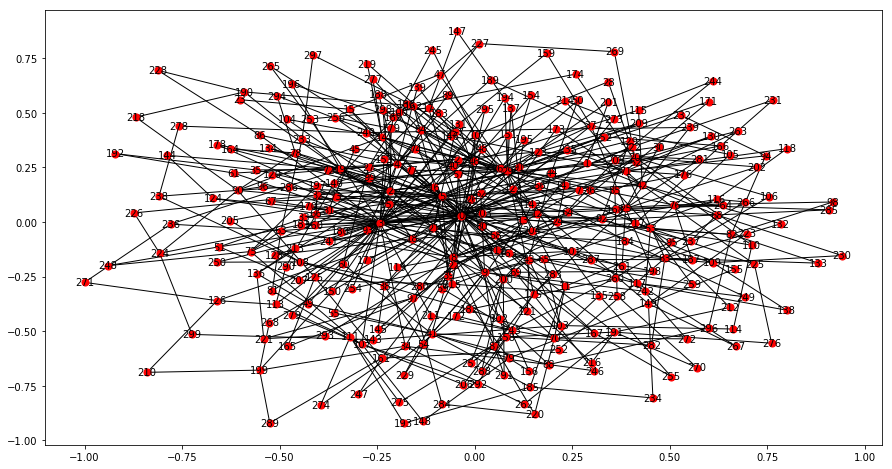

In [100]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [101]:
rand_failures = execute_failures_pool(G, random_ranking)

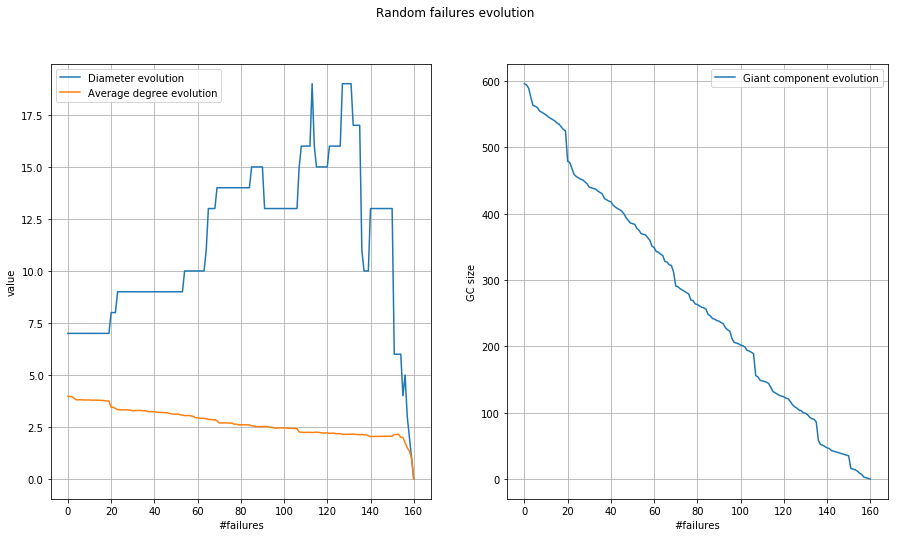

In [102]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

As discussed above, random failures spend more time compared to the targeted attack.

The critical fraction of nodes is less compared with the fraction required for the random network: this is due to the fact that in this graph there is the presence of hubs and if someone is selected, their removing affects a lot the diameter and the giant component size.

### -- attacks over closeness

In [103]:
cls_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

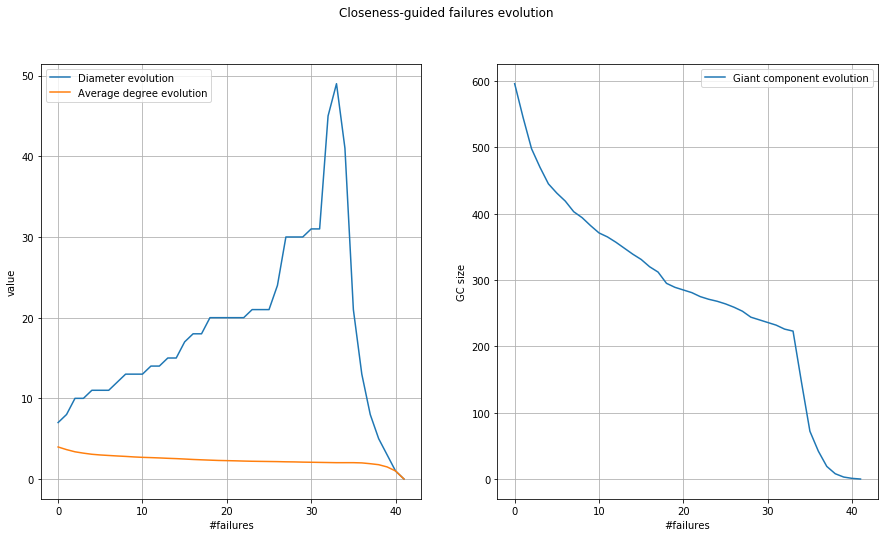

In [104]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [105]:
btw_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

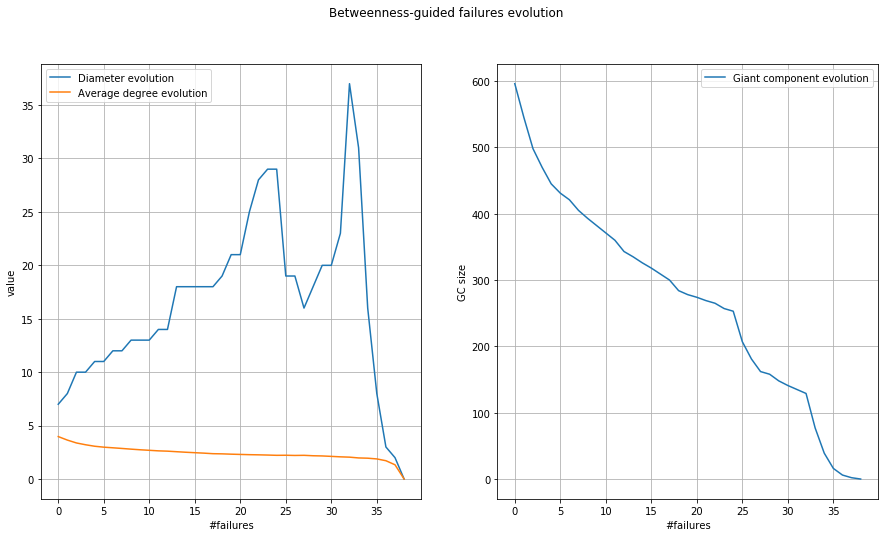

In [106]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over nodes degree

In [107]:
deg_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.degree})

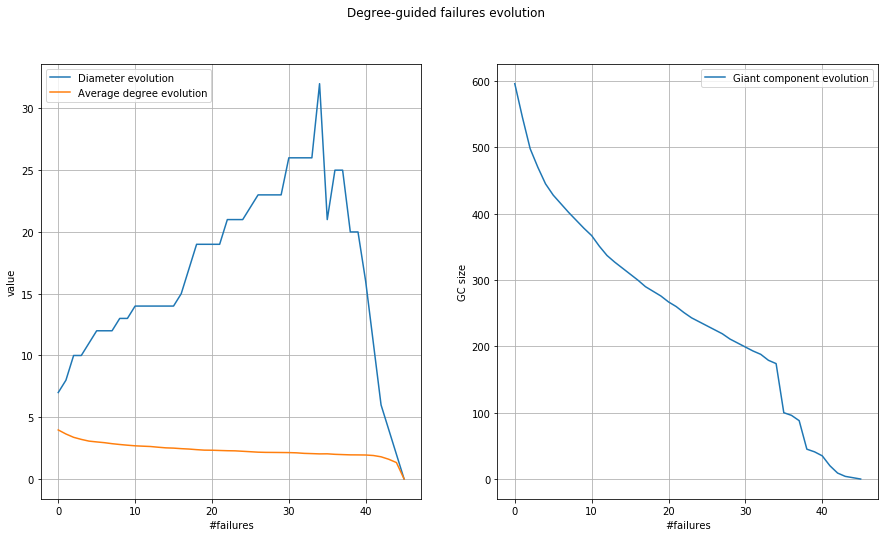

In [108]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over clustering coefficient

In [109]:
clt_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.clustering})

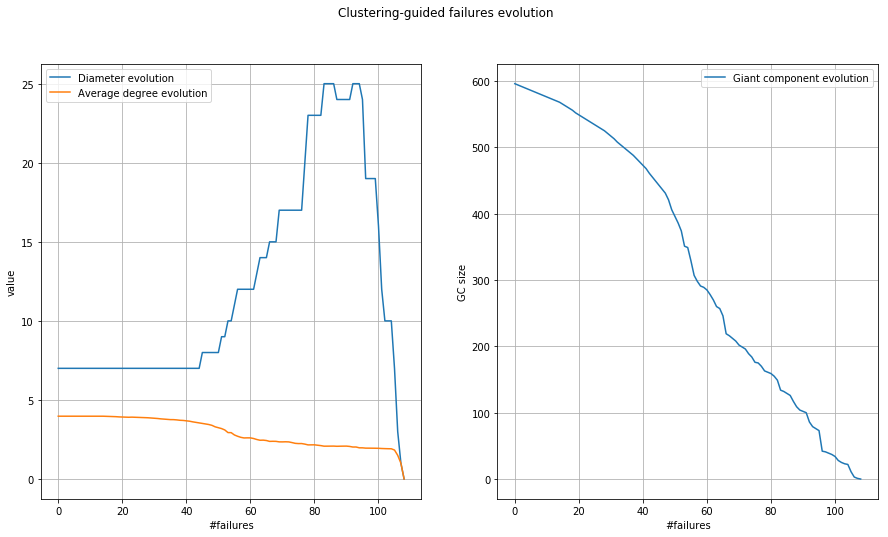

In [110]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [111]:
prk_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

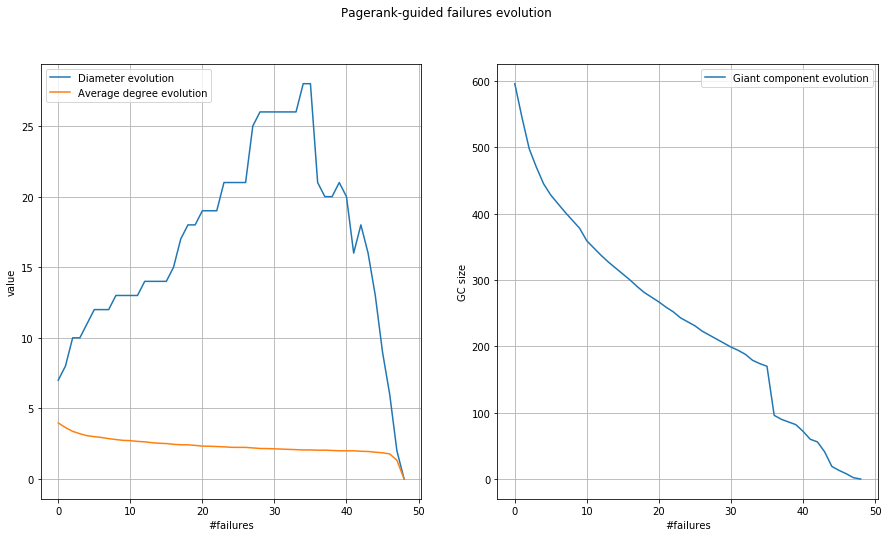

In [112]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [113]:
hit_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

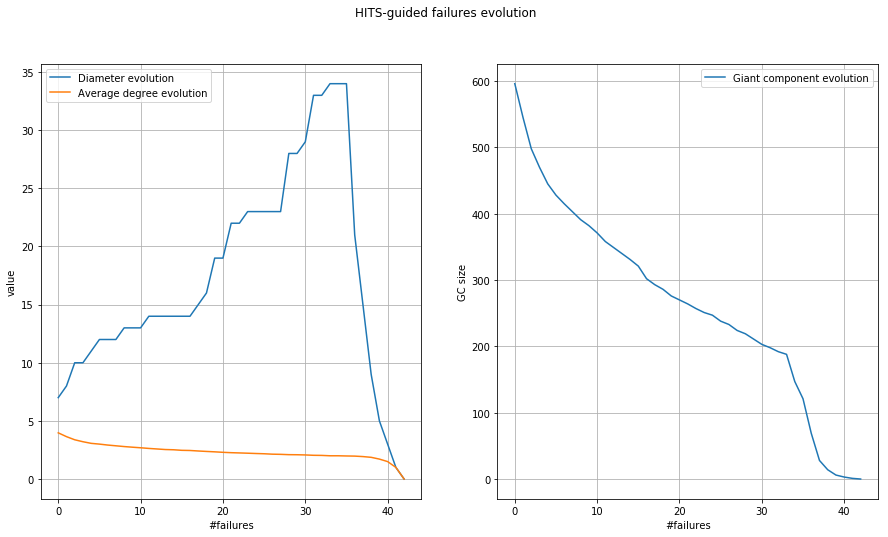

In [114]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

In the other attacks, the fraction of nodes is lower, especially in the betweenness and closeness cases: this remarks the fact that hubs are of fundamental importance in terms of communication.

### -- attack comparison

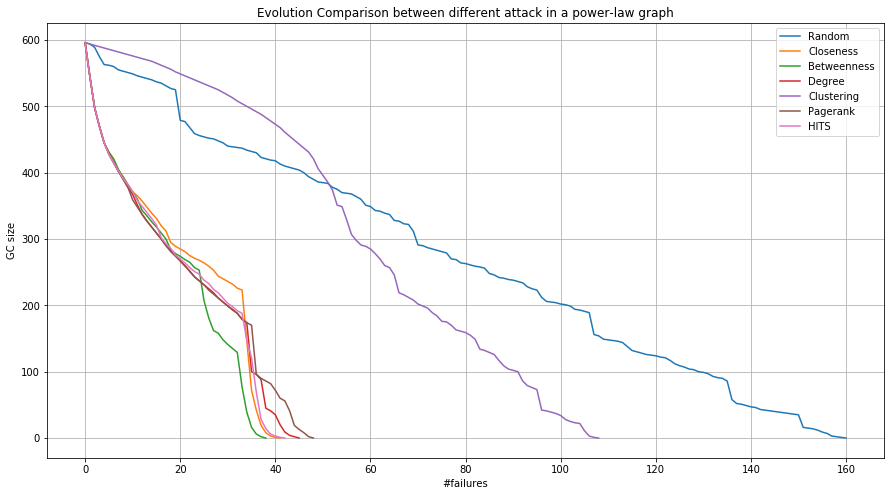

In [115]:
compare_attack(attackDict, "power-law")

In this last plot, random failures require the deletion of more node (as expected), whereas the attacks based on the other centrality measures, above all betweenness, require fewer failures.

The clustering coefficient guided attacks perform worst with respect the others: the lower clustering coefficient, the more importance a node have (this is an indicator of structural holes and so of the dissortative “hubs” characteristic of the node).

## 3. Real Graph - arXiv collaboration on general relativity

In [40]:
attackDict = {}

In [41]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

Number of nodes: 5242
Number of edges: 14496


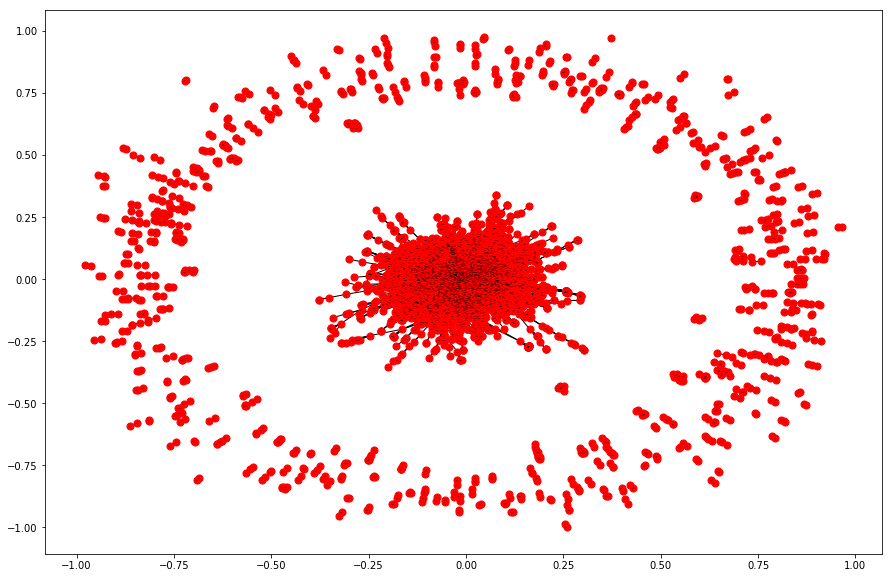

In [42]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random failures

In [43]:
rand_failures = execute_failures_pool(G, random_ranking)

KeyboardInterrupt: 

In [ ]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

### -- attacks over closeness

In [ ]:
cls_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

In [ ]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [ ]:
btw_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

In [ ]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over nodes degree

In [ ]:
deg_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.degree})

In [ ]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over clustering coefficient

In [ ]:
clt_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.clustering})

In [ ]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prk_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

In [ ]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hit_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

In [ ]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

### -- attack comparison

In [ ]:
compare_attack(attackDict, "real")

# Others outdated methods

In [ ]:
def execute_failures_2processes(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    i = 0
    
    diam_evol = multiprocessing.Manager().dict({i:nx.diameter(workingG)})
    deg_evol = multiprocessing.Manager().dict({i:np.mean(list(dict(workingG.degree).values()))})
    giant_evol = multiprocessing.Manager().dict({i:workingG.size()})
    
    while len(workingG)>1:        
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)
        
        i+=1

        if (i%2==1):
            t1 = multiprocessing.Process(target=work, args=(workingG.copy(), i, diam_evol, deg_evol, giant_evol))
            p=t1
            t1.start()
            if(i!=1):
                t2.join()
        else:
            t2 = multiprocessing.Process(target=work, args=(workingG.copy(), i, diam_evol, deg_evol, giant_evol))
            p=t2
            t2.start()
            t1.join()
            
    p.join()
    
    diam_evol=list(map(lambda p:p[1], sorted(diam_evol.items(), key=lambda p:p[0])))
    deg_evol=list(map(lambda p:p[1], sorted(deg_evol.items(), key=lambda p:p[0])))
    giant_evol=list(map(lambda p:p[1], sorted(giant_evol.items(), key=lambda p:p[0])))
    
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def execute_failures_connected(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    diam_evol = [nx.diameter(workingG)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [len(workingG)]
    
    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        if nx.is_connected(workingG):
            diam_evol.append(nx.diameter(workingG))
            giant_evol.append(len(workingG))
        else:
            diam_evol.append(0)
            giant_evol.append(0)
        
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        
         
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}